# **3-Perform sentiment analysis using Deep Learning**
Optimisation of the final model here Glove with the LSTM.

We choose this model because as we have seen, it's the one which gives us better performance with a correct training time.

In [1]:
glove_embed = '../glove_emb/train_tweet_emb/glove.twitter.27B.100d.txt'
df_clean = '../data/df_clean.csv'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import time
import pickle

from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import SparseCategoricalAccuracy
from plot_keras_history import show_history, plot_history
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

In [3]:
# Version of the libraries used
print('\n'.join(f'{m.__name__} - {m.__version__}'
                for m in globals().values()
                if getattr(m, '__version__', None)))

numpy - 1.26.3
pandas - 2.2.0
mlflow - 2.10.0


---

In [4]:
# Read the cleaned and processing CSV file
df = pd.read_csv(df_clean, encoding='latin1')

In [5]:
# Prepare training data
sentences = df['text'].astype(str)
labels = df['target']

# Initialize the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

# Save the tokenizer
with open('../glove_emb/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Transform sentences into sequences
sequences = tokenizer.texts_to_sequences(sentences)

# Padding sequences so that they are all the same length
data = pad_sequences(sequences)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=5)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=5)

In [6]:
# Load GloVe embeddings
embeddings_index = {}
with open(glove_embed, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [7]:
# Prepare the embeddings matrix
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [8]:
# Build the model
optimized_glove = Sequential()
optimized_glove.add(Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], trainable=False))
optimized_glove.add(LSTM(128))
optimized_glove.add(Dense(2, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=5e-5)
loss = SparseCategoricalCrossentropy(from_logits=True)
metric = SparseCategoricalAccuracy('accuracy')

optimized_glove.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [9]:
# Start an experiment
with mlflow.start_run(run_name="Optimized Glove LSTM"):
    # Log parameters
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("learning_rate", 5e-5)
    mlflow.log_param("loss_function", "SparseCategoricalCrossentropy")
    mlflow.log_param("metric", "SparseCategoricalAccuracy")
    mlflow.log_param("batch_size", 64)
    mlflow.log_param("epochs", 40)

    # Define callbacks
    checkpoint = ModelCheckpoint('../glove_emb/best_glove_embed.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, mode='max')

    # Train the model
    start_time = time.time()
    history_optimized_glove = optimized_glove.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=40, callbacks=[checkpoint, early_stopping])
    end_time = time.time()

    # Log model
    mlflow.sklearn.log_model(optimized_glove, "optimized_glove")

    # Register model to the model registry
    run_id = mlflow.active_run().info.run_id
    mlflow.register_model(f"runs:/{run_id}/model", "Model Optimized Glove")

    # Log metrics
    mlflow.log_metric("accuracy", history_optimized_glove.history['accuracy'][-1])
    mlflow.log_metric("val_accuracy", history_optimized_glove.history['val_accuracy'][-1])

time_optimized_glove = end_time - start_time
print(f"Training Time --> {time_optimized_glove}")

Epoch 1/40



c:\Users\julia\Desktop\Projet #7\.env\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


15000/15000 [==============================] - ETA: 0s - loss: 0.5096 - accuracy: 0.7486
Epoch 1: val_accuracy improved from -inf to 0.76283, saving model to ../glove_emb\best_glove_embed.h5


c:\Users\julia\Desktop\Projet #7\.env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15000/15000 [==============================] - 261s 17ms/step - loss: 0.5096 - accuracy: 0.7486 - val_loss: 0.4876 - val_accuracy: 0.7628
Epoch 2/40
14997/15000 [============================>.] - ETA: 0s - loss: 0.4782 - accuracy: 0.7691
Epoch 2: val_accuracy improved from 0.76283 to 0.77268, saving model to ../glove_emb\best_glove_embed.h5
15000/15000 [==============================] - 252s 17ms/step - loss: 0.4782 - accuracy: 0.7691 - val_loss: 0.4733 - val_accuracy: 0.7727
Epoch 3/40
14997/15000 [============================>.] - ETA: 0s - loss: 0.4674 - accuracy: 0.7760
Epoch 3: val_accuracy improved from 0.77268 to 0.77775, saving model to ../glove_emb\best_glove_embed.h5
15000/15000 [==============================] - 250s 17ms/step - loss: 0.4674 - accuracy: 0.7760 - val_loss: 0.4651 - val_accuracy: 0.7777
Epoch 4/40
14998/15000 [============================>.] - ETA: 0s - loss: 0.4609 - accuracy: 0.7801
Epoch 4: val_accuracy improved from 0.77775 to 0.78087, saving model to ../g

c:\Users\julia\Desktop\Projet #7\.env\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Training Time --> 7939.595215320587


Registered model 'Model Optimized Glove' already exists. Creating a new version of this model...
Created version '2' of model 'Model Optimized Glove'.


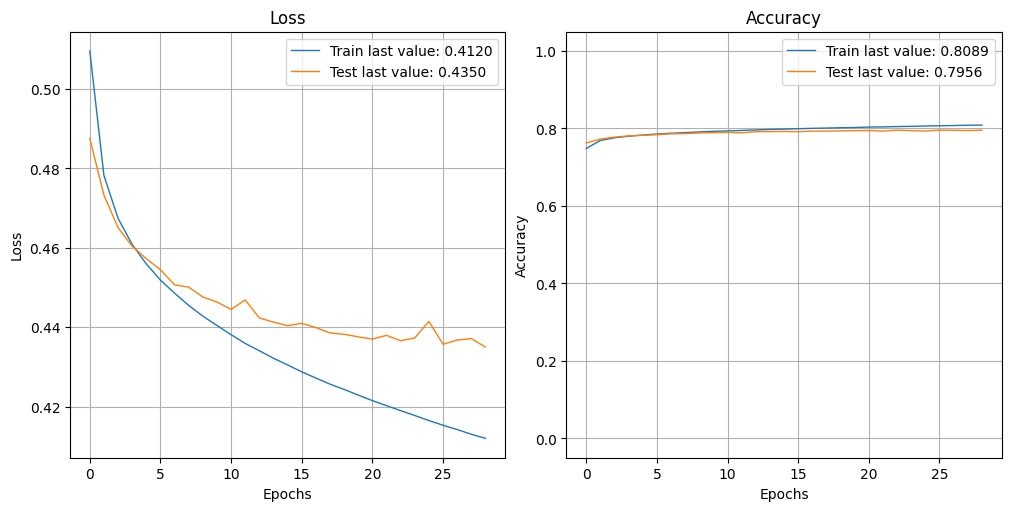

In [10]:
show_history(history_optimized_glove)
plot_history(history_optimized_glove, path="../history_models/optimized_glove.png")
plt.close()

In [11]:
# Load the best model
optimized_glove = load_model('../glove_emb/best_glove_embed.h5')

# Evaluate the model on the test set
loss, accuracy_optimized_glove = optimized_glove.evaluate(X_test, y_test, verbose=0)
print('Loss: %.2f' % loss)
print('Accuracy: %.2f' % (accuracy_optimized_glove*100))

Loss: 0.44
Accuracy: 79.40
